# ESM1.6 Scaling

End-to-end pipeline generating scaling plots for ESM1.6 Pre-industrial configuration (WIP).

In [ ]:
## Prerequisites

# payu/dev has experiment-generator and experiment-runner built-in, 
# so best to run those commands from CLI.
# module use /g/data/vk83/prerelease/modules && module load payu/dev

# install prerequisites for parsing profiling data
!pip install git+https://github.com/ACCESS-NRI/access-parsers

  Cloning https://github.com/ACCESS-NRI/access-experiment-generator to /scratch/tm70/ey7514/tmp/pip-req-build-qolko6ys
  Running command git clone --filter=blob:none --quiet https://github.com/ACCESS-NRI/access-experiment-generator /scratch/tm70/ey7514/tmp/pip-req-build-qolko6ys
  Resolved https://github.com/ACCESS-NRI/access-experiment-generator to commit 9d09aeb5c8badab6e0d4fe3d335100f6d2b3d099
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/ACCESS-NRI/access-experiment-runner to /scratch/tm70/ey7514/tmp/pip-req-build-n6m70k10
  Running command git clone --filter=blob:none --quiet https://github.com/ACCESS-NRI/access-experiment-runner /scratch/tm70/ey7514/tmp/pip-req-build-n6m70k10
  Resolved https://github.com/ACCESS-NRI/access-experiment-runner to commit 495a6fd54de1ad24dd954fe3eebf13d68f2c059d
  Installing build dependencies ... done
  Getting requirements to build w

## Running model AKA generating scaling data

This uses the experiment generator CLI utility with a config file.

In [ ]:
# this is best done on CLI
!which experiment-generator
!experiment-generator -i configs/esm1.6.yaml

~/scratch-tm70/scaling/.venv/bin/experiment-generator
-- Test directory esm1.6-scaling already exists!
-- Test dir: /scratch/tm70/ey7514/scaling/access-models-scaling/esm1.6-scaling/PI_concentrations already exists, hence not cloning git@github.com:ACCESS-NRI/access-esm1.6-configs.git
Checked out branch: ctrl
laboratory path:  /scratch/tm70/ey7514/access-esm
binary path:  /scratch/tm70/ey7514/access-esm/bin
input path:  /scratch/tm70/ey7514/access-esm/input
work path:  /scratch/tm70/ey7514/access-esm/work
archive path:  /scratch/tm70/ey7514/access-esm/archive
Found experiment archive: /scratch/tm70/ey7514/access-esm/archive/PI_concentrations-ctrl-f4573297
Removed archive symlink to /scratch/tm70/ey7514/access-esm/archive/PI_concentrations-8nodes-d3e10f9f
Added archive symlink to /scratch/tm70/ey7514/access-esm/archive/PI_concentrations-ctrl-f4573297
-- Branch 1nodes already exists, switching to it only!
Checked out branch: 1nodes
laboratory path:  /scratch/tm70/ey7514/access-esm
binary

In [6]:
# generate runner config. It's relatively simple, so writing the config here.
with open("runner.yaml", 'w') as f:
    f.write("""
test_path: esm1.6-scaling/
repository_directory: PI_concentrations
# these branches need to match branches in configs/esm1.6.yaml
running_branches: 
    - 1nodes
    - 2nodes
    - 4nodes
    - 8nodes 
keep_uuid: True

# currently nruns != 1 doesn't work.
nruns: [1, 1, 1, 1]
startfrom_restart: [cold, cold, cold, cold]
""")

# janky sys cmd to use payu/dev with experiment-runner.
# prefer not to load payu dev prior loading as it might not have 
# correct version of experiment-generator.
!module use /g/data/vk83/prerelease/modules && module load payu/dev && experiment-runner -i runner.yaml

Loading payu/dev-20250917T072949Z-a662f10
  Loading requirement: singularity
>/g/data/vk83/prerelease/apps/conda_scripts/payu-dev-20250917T072949Z-a662f10.d/bin/experiment-runner: line 121: /g/data/vk83/prerelease/apps/base_conda/envs/payu-dev-20250917T072949Z-a662f10/bin/experiment-runner: No such file or directory


After running the experiment, you should have:
* a directory containing branches for each experiment
* a directory for each experiment result
    * the results will be in corresponding 'archive' directories

In [14]:
# you should have:
# * a directory containing branches for each expeiriment
!tree -dL 3 esm1.6-scaling

esm1.6-scaling
├── 1nodes
│   └── PI_concentrations
│       ├── archive -> /scratch/tm70/ey7514/access-esm/archive/PI_concentrations-1nodes-918ff1b1
│       ├── atmosphere
│       ├── coupler
│       ├── ice
│       ├── manifests
│       ├── ocean
│       ├── scripts
│       └── testing
├── 2nodes
│   └── PI_concentrations
│       ├── archive -> /scratch/tm70/ey7514/access-esm/archive/PI_concentrations-2nodes-f5b4f8cc
│       ├── atmosphere
│       ├── coupler
│       ├── ice
│       ├── manifests
│       ├── ocean
│       ├── scripts
│       └── testing
├── 4nodes
│   └── PI_concentrations
│       ├── archive -> /scratch/tm70/ey7514/access-esm/archive/PI_concentrations-4nodes-223a8b9f
│       ├── atmosphere
│       ├── coupler
│       ├── ice
│       ├── manifests
│       ├── ocean
│       ├── scripts
│       └── testing
├── 8nodes
│   └── PI_concentrations
│       ├── archive -> /scratch/tm70/ey7514/access-esm/archive/PI_concentrations-8nodes-d3e10f9f
│       ├── atmosphere
│       ├

## Parsing experiment results

We'll use the profiling parsers in access-parsers to do this.

In [15]:
# Draft post-processing functions (these would be put into some sort of module)

from typing import List
from collections.abc import Iterable
from access.parsers.profiling import ProfilingParser
import xarray as xr


def parse_profiling_data(
    logs: List[str], parser: ProfilingParser, varname: str, vars: Iterable
):

    datasets = []
    for var, log in zip(vars, logs):
        data = parser.read(log)
        datasets.append(
            xr.Dataset(
                data_vars=dict(
                    zip(
                        parser.metrics,
                        [
                            xr.DataArray([data[metric]], dims=[varname, "region"])
                            for metric in parser.metrics
                        ],
                    )
                ),
                coords={"region": data["region"], varname: [var]},
            )
        )
    return xr.concat(datasets, dim=varname)


def scaling_speedup(stats: xr.Dataset, metric: str = "tavg") -> xr.Dataset:
    """Calculates the parallel speedup from scaling data.

    Args:
        stats (Dataset): Scaling data, stored as a xarray dataset.

    Returns:
        Dataset: Parallel speedup.
    """
    speedup = stats[metric].sel(ncpus=stats["ncpus"].min()) / stats[metric]
    speedup.name = "speedup"
    return speedup


def scaling_efficiency(stats: xr.Dataset, metric: str = "tavg") -> xr.Dataset:
    """Calculates the parallel efficiency from scaling data.

    Args:
        stats (Dataset): Scaling data, stored as a xarray dataset.

    Returns:
        Dataset: Parallel efficiency.
    """
    speedup = scaling_speedup(stats, metric)
    eff = speedup / speedup.ncpus * 100 * stats["ncpus"].min()
    eff.name = "parallel efficiency [%]"
    return eff

In [ ]:
# plotting functions. Might want to keep these in the notebook so they're modifiable by the user?

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def calculate_column_widths(table_data, first_col_flexible=True):
    """
    Calculate column widths based on content length

    Args:
        table_data (List[list]): Table data including headers
        first_col_flexible (bool): If True, first column gets remaining space after others are sized

    Returns:
        list : Column width ratios
    """
    if not table_data:
        return []

    n_cols = len(table_data[0])

    # Calculate max content length for each column
    max_lengths = []
    for col in range(n_cols):
        col_lengths = [len(str(row[col])) for row in table_data]
        max_lengths.append(max(col_lengths))

    if first_col_flexible:
        # Set data columns to proportional widths based on content
        # Give first column remaining space
        data_cols_total = sum(max_lengths[1:])
        base_width = 0.6 / data_cols_total if data_cols_total > 0 else 0.1

        col_widths = [0.4]  # First column gets 40% of space
        for length in max_lengths[1:]:
            col_widths.append(length * base_width)

        # Adjust to sum to 1.0
        current_sum = sum(col_widths)
        col_widths = [w / current_sum for w in col_widths]

        # Give first column any remaining space
        remaining = 1.0 - sum(col_widths[1:])
        col_widths[0] = remaining
    else:
        # Proportional to content length
        total_length = sum(max_lengths)
        col_widths = [length / total_length for length in max_lengths]

    return col_widths


def plot_regions(
    stats: List[xr.Dataset],
    regions: List[List[str]],
    metrics: List[str],
    xcoordinate: str = "ncpus",
):
    """Plots scaling speedup and efficiency from a list of datasets

    Args:
        stats (List[xr.Dataset]): The raw times to plot.
        regions (List[List[str]]): The list of regions to plot.
            regions[0][:] corresponds to regions to plot in stats[0].
        metrics (List[str]): The metrics to plot for each stat.
        xcoordinate (str): The x-axis variable e.g. ncpus.
    """
    # setup plots
    fig = plt.figure(figsize=(15, 6))
    # using gridspec so table can be added
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], hspace=0.3)
    ax1, ax2 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])
    ax_tbl = fig.add_subplot(gs[1, :])

    # add table of raw timings
    tbl = [[xcoordinate] + list(stats[0][xcoordinate].values)]  # first row
    for stat, region, metric in zip(stats, regions, metrics):

        # calculate efficiency and speedup
        efficiency = scaling_efficiency(stat, metric)
        speedup = scaling_speedup(stat, metric)

        # plots speedup and efficiency on their respective axes.
        max_eff = 100
        for r in region:
            speedup.loc[r, :].plot.line(x=xcoordinate, ax=ax1, marker="o", label=r)
            efficiency.loc[r, :].plot.line(x=xcoordinate, ax=ax2, marker="o", label=r)
            # find max efficiency for setting efficiency axis
            max_eff = max(max_eff, efficiency.loc[r, :].max())

        tbl.append([region] + [f"{val:.2f}" for val in stat[metric].loc[:, r].values])

    # ideal speedup/scaling
    minx = stat[xcoordinate].values.min()
    nx = len(stat[xcoordinate].values)
    ideal_speedups = [i / minx for i in stat[xcoordinate].values]
    ax1.plot(stat[xcoordinate].values, ideal_speedups, "k:", label="ideal")
    ax2.plot(stat[xcoordinate].values, [100] * nx, "k:", label="ideal")

    # formatting
    ax1.legend()
    ax1.grid()
    ax2.grid()
    ax2.set_ylim((0, 1.1 * max_eff))
    ax1.set_title("Scaling Speedup")
    ax2.set_title("Scaling Efficiency")
    ax_tbl.axis("off")
    tbl_chart = ax_tbl.table(
        tbl,
        bbox=(0.05, 0, 0.9, 1),
        cellLoc="center",
        colWidths=calculate_column_widths(tbl),
    )
    ax_tbl.set_title("Timings (s)")
    for i in range(len(tbl[0])):
        tbl_chart[(0, i)].set_text_props(weight="bold")
    for i in range(len(tbl)):
        tbl_chart[(i, 0)].set_text_props(weight="bold")

In [17]:
# Start by processing FMS (MOM5) results
from access.parsers.fms_profiling import FMSProfilingParser
from access.parsers.payujson_profiling import PayuJSONProfilingParser
fmsparser = FMSProfilingParser(has_hits=False)
payuparser = PayuJSONProfilingParser()

In [18]:
# Processing logs
from pathlib import Path
import glob

fmslogs = []
payulogs = []
for nnodes in (1, 2, 4, 8):
    archive_dir = f"esm1.6-scaling/{nnodes}nodes/PI_concentrations/archive"
    with open(archive_dir + "/output000/access-esm1.6.out", "r") as f:
        fmslogs.append(f.read())
    payulog = glob.glob(archive_dir + "/payu_jobs/0/run/*.gadi-pbs.json")[0]
    with open(payulog, "r") as f:
        payulogs.append(f.read())

In [19]:
fmsstats = parse_profiling_data(
    fmslogs,
    fmsparser,
    "ncpus",
    [104, 208, 416, 832]
)
fmsstats

<xarray.Dataset> Size: 70kB
Dimensions:  (ncpus: 4, region: 183)
Coordinates:
  * region   (region) <U32 23kB 'Total runtime' 'Ocean' ... 'oasis_send'
  * ncpus    (ncpus) int64 32B 104 208 416 832
Data variables:
    tmin     (ncpus, region) float64 6kB 1.628e+04 1.597e+04 ... 0.9289
    tmax     (ncpus, region) float64 6kB 1.628e+04 1.6e+04 ... 4.128e+03 1.445
    tavg     (ncpus, region) float64 6kB 1.628e+04 1.599e+04 ... 4.06e+03 1.092
    tstd     (ncpus, region) float64 6kB 1e-06 8.644 0.00147 ... 25.68 0.1059
    tfrac    (ncpus, region) float64 6kB 1.0 0.982 0.0 0.0 ... 0.0 0.0 0.601 0.0
    grain    (ncpus, region) int64 6kB 0 1 11 11 31 31 31 ... 31 41 41 1 1 31 31
    pemin    (ncpus, region) int64 6kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    pemax    (ncpus, region) int64 6kB 48 48 48 48 48 48 ... 391 391 391 391 391

In [ ]:
# first 10 regions
fmsstats.region[:10]

<xarray.DataArray 'region' (region: 10)> Size: 1kB
array(['Total runtime', 'Ocean', '(Ocean initialization)', '(Ocean ODA)',
       '(Red Sea/Gulf Bay salinity fix)', '(Ocean advection velocity)',
       '(Ocean density diag)', '(Ocean update density)',
       '(Ocean vertical mixing coeff)', '(Ocean neutral physics)'],
      dtype='<U32')
Coordinates:
  * region   (region) <U32 1kB 'Total runtime' ... '(Ocean neutral physics)'

In [22]:
payustats = parse_profiling_data(
    payulogs,
    payuparser,
    "ncpus",
    [104, 208, 416, 832]
)
payustats.region

<xarray.DataArray 'region' (region: 5)> Size: 620B
array(['payu_setup_duration_seconds', 'payu_model_run_duration_seconds',
       'payu_run_duration_seconds', 'payu_archive_duration_seconds',
       'payu_total_duration_seconds'], dtype='<U31')
Coordinates:
  * region   (region) <U31 620B 'payu_setup_duration_seconds' ... 'payu_total...

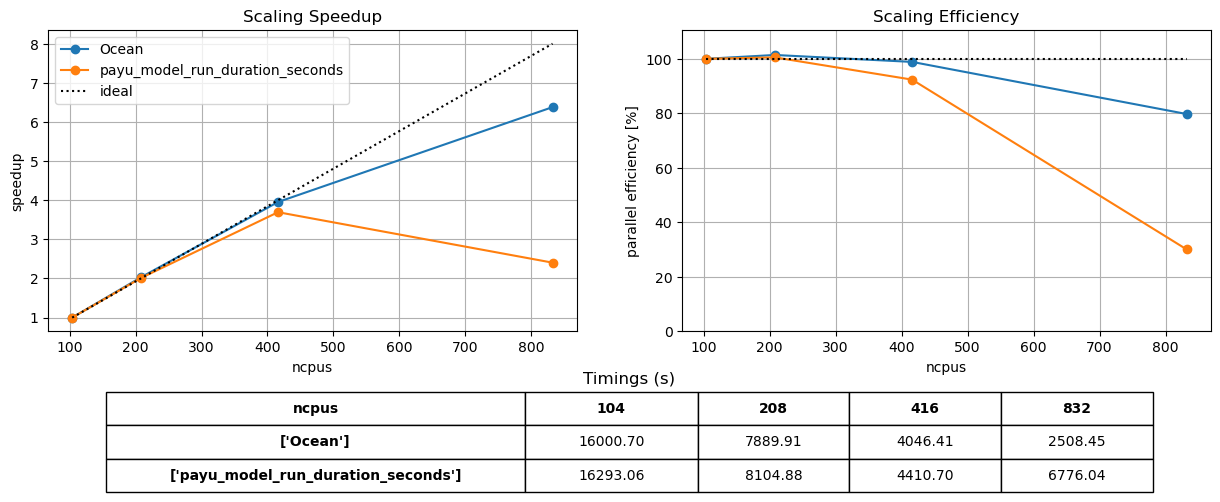

In [24]:
# plots the Ocean region and tmax metric from the FMS stats, and 
# payu_model_run_duration_seconds region and walltime metric from payu stats.
plot_regions(
    stats=[fmsstats, payustats], 
    regions=[
        ["Ocean"], 
        ["payu_model_run_duration_seconds"]
    ], 
    metrics=["tmax", "walltime"]
)